This notebook applies an inverted Transformer model using PyTorch & Lightning, to get multi-step quantile energy consumption forecasts. 

It also performs & demonstrates the necessary data handling & preprocessing steps to get source & target sequences for the Transformer model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import lightning as L
import optuna
import warnings

from lightning.pytorch.callbacks import Callback
from optuna.integration import PyTorchLightningPruningCallback
from src.deep_learning.preprocessing import SequenceScaler, SequenceDataset
from src.deep_learning.quantile_loss import QuantileLoss
from src.deep_learning.transformer import LITransformer
from src.deep_learning.testing import train_val_split, test_sequences_to_dataframe, plot_actual_predicted, plot_sequence_preds, calculate_metrics
from src.deep_learning.prediction import predictions_to_dataframe

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
random_seed = 1923

In [4]:
# Set Torch settings
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')
L.seed_everything(random_seed, workers = True)
warnings.filterwarnings("ignore", ".*does not have many workers.*")

Seed set to 1923


In [5]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [8]:
data_dir = "../data/processed/"

In [9]:
df = pd.read_csv(data_dir + "train_data.csv")
df["time"] = pd.to_datetime(df["time"])

In [10]:
df

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2018-01-01 02:00:00,24635.32,27412.81,2,7.071068e-01,7.071068e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
1,2018-01-01 03:00:00,23872.12,26324.39,3,8.660254e-01,5.000000e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
2,2018-01-01 04:00:00,23194.89,24635.32,4,9.659258e-01,2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
3,2018-01-01 05:00:00,23071.96,23872.12,5,1.000000e+00,6.123234e-17,7.818315e-01,0.62349,5.000000e-01,0.866025
4,2018-01-01 06:00:00,23267.90,23194.89,6,9.659258e-01,-2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
52577,2023-12-31 19:00:00,35090.93,34549.42,52579,-8.660254e-01,5.000000e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52578,2023-12-31 20:00:00,33310.94,36193.59,52580,-7.071068e-01,7.071068e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52579,2023-12-31 21:00:00,32083.96,35090.93,52581,-5.000000e-01,8.660254e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52580,2023-12-31 22:00:00,30469.49,33310.94,52582,-2.588190e-01,9.659258e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000


## Data prep: Getting input & output sequences

We will create a "shifted dataset" where each row at time T contains the following columns:
- Target value at T (consumption lead T+1),
- Past value at T (consumption lag T-2),
- Time covariates at T.

In [11]:
# Get shifted dataset, drop last row due to unknown target
df_shifted = df.copy()
df_shifted["consumption_MWh"] = df_shifted.consumption_MWh.shift(-1)
df_shifted = df_shifted.dropna()

In [12]:
df_shifted

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2018-01-01 02:00:00,23872.12,27412.81,2,0.707107,7.071068e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
1,2018-01-01 03:00:00,23194.89,26324.39,3,0.866025,5.000000e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
2,2018-01-01 04:00:00,23071.96,24635.32,4,0.965926,2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
3,2018-01-01 05:00:00,23267.90,23872.12,5,1.000000,6.123234e-17,7.818315e-01,0.62349,5.000000e-01,0.866025
4,2018-01-01 06:00:00,23875.44,23194.89,6,0.965926,-2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
52576,2023-12-31 18:00:00,35090.93,32670.06,52578,-0.965926,2.588190e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52577,2023-12-31 19:00:00,33310.94,34549.42,52579,-0.866025,5.000000e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52578,2023-12-31 20:00:00,32083.96,36193.59,52580,-0.707107,7.071068e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52579,2023-12-31 21:00:00,30469.49,35090.93,52581,-0.500000,8.660254e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000


Every source sequence will be the last 72 hours before 16:00, and every target sequence will be the next 32 hours after 16:00.

In [13]:
# Set fixed parameters
n_steps = len(df_shifted) 
source_length = 72 # T-L to T hours
source_dims = 8 # Consumption lag 2, trend, 6 cyclical columns as features
target_length = 32 # We are only interested in predicting T+8 to 32, but we'll make this a model parameter
horizon_start = 0 # Output step to start loss calculation from
quantiles = [0.025, 0.5, 0.975] # Quantiles to predict

In [14]:
# Find the index of the first 16:00 row in the data, where the index is bigger than source_length - 1. This will be the first T.
first_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index >= source_length - 1)].index.values[0]

In [15]:
first_t 

86

In [16]:
# Find the index of the last 16:00 row in the data, with 32 time steps after it. This will be the last T.
last_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index + target_length - 1 <= df.index.values[-1])].index.values[-2]

In [17]:
last_t 

52526

Each source sequence will contain the following:
- Consumption lag 2 at [T - source_length, T] (past targets),
- Time covariates at [T - source_length, T] (past covariates).

In [18]:
# One source sequence
source_seq = pd.concat([
    df_shifted.iloc[(first_t - source_length):first_t, 0], # Time
    df_shifted.iloc[(first_t - source_length):first_t, 2], # Past target
    df_shifted.iloc[(first_t - source_length):(first_t), 3:] # Past covariates
], axis = 1)

Each output sequence will contain the following:
- Consumption at [T+1, T + output_length] (future targets),
- Time covariates at [T+1, T + output_length] (future known covariates)

In [19]:
# One output sequence
target_seq = pd.concat([
    df_shifted.iloc[first_t:(first_t + target_length), 0], # Time 
    df_shifted.iloc[first_t:(first_t + target_length), 1], # Future target
    df_shifted.iloc[first_t:(first_t + target_length), 3:] # Future known covariates
], axis = 1)

In [20]:
source_seq.iloc[-5:]

,time,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
81,2018-01-04 11:00:00,39641.36,83,1.224647e-16,-1.000000,-0.433884,-0.900969,0.5,0.866025
82,2018-01-04 12:00:00,40593.83,84,-2.588190e-01,-0.965926,-0.433884,-0.900969,0.5,0.866025
83,2018-01-04 13:00:00,40955.07,85,-5.000000e-01,-0.866025,-0.433884,-0.900969,0.5,0.866025
84,2018-01-04 14:00:00,39505.55,86,-7.071068e-01,-0.707107,-0.433884,-0.900969,0.5,0.866025
85,2018-01-04 15:00:00,39635.29,87,-8.660254e-01,-0.500000,-0.433884,-0.900969,0.5,0.866025


In [21]:
target_seq[:5]

,time,consumption_MWh,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
86,2018-01-04 16:00:00,40487.65,88,-0.965926,-2.588190e-01,-0.433884,-0.900969,0.5,0.866025
87,2018-01-04 17:00:00,39936.25,89,-1.000000,-1.836970e-16,-0.433884,-0.900969,0.5,0.866025
88,2018-01-04 18:00:00,38772.68,90,-0.965926,2.588190e-01,-0.433884,-0.900969,0.5,0.866025
89,2018-01-04 19:00:00,38113.86,91,-0.866025,5.000000e-01,-0.433884,-0.900969,0.5,0.866025
90,2018-01-04 20:00:00,36758.94,92,-0.707107,7.071068e-01,-0.433884,-0.900969,0.5,0.866025


In [22]:
df_shifted.iloc[81:90]

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
81,2018-01-04 11:00:00,39505.55,39641.36,83,1.224647e-16,-1.000000e+00,-0.433884,-0.900969,0.5,0.866025
82,2018-01-04 12:00:00,39635.29,40593.83,84,-2.588190e-01,-9.659258e-01,-0.433884,-0.900969,0.5,0.866025
83,2018-01-04 13:00:00,39952.75,40955.07,85,-5.000000e-01,-8.660254e-01,-0.433884,-0.900969,0.5,0.866025
84,2018-01-04 14:00:00,39649.45,39505.55,86,-7.071068e-01,-7.071068e-01,-0.433884,-0.900969,0.5,0.866025
85,2018-01-04 15:00:00,40063.17,39635.29,87,-8.660254e-01,-5.000000e-01,-0.433884,-0.900969,0.5,0.866025
86,2018-01-04 16:00:00,40487.65,39952.75,88,-9.659258e-01,-2.588190e-01,-0.433884,-0.900969,0.5,0.866025
87,2018-01-04 17:00:00,39936.25,39649.45,89,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.5,0.866025
88,2018-01-04 18:00:00,38772.68,40063.17,90,-9.659258e-01,2.588190e-01,-0.433884,-0.900969,0.5,0.866025
89,2018-01-04 19:00:00,38113.86,40487.65,91,-8.660254e-01,5.000000e-01,-0.433884,-0.900969,0.5,0.866025


In the source sequence, we pair every past target value at T with the past covariates at T.
\
In the output sequence, we pair every future target value at T+1 with the future covariates at T+1.

This is more straightforward than the LSTM sequencing in notebook 4.0, because we will make our predictions in one go, and don't need to combine predictions at T+1 with future covariates at T+2 to get the input sequence for T+1. 

We will simply initialize the future targets from T+1 onwards as a linear extrapolation of the past targets from T - source_length to T. We'll do this in training as well as validation & prediction.
\
The idea is that the model should learn to "enrich" a simple linear extrapolation given additional future known covariates.

In [23]:
n_sequences = (last_t - first_t) // 24 + 1 # Number of 16:00 rows followed by a sufficient length source / target sequence
print("Number of possible sequences: " + f"{n_sequences}")

Number of possible sequences: 2186


In [24]:
# Initialize lists of sequences
source_sequences = []
target_sequences = []

# Get all sequences
for t in range(first_t, last_t + 1, 24):

    # Get source sequence
    new_source = pd.concat([
        df_shifted.iloc[(t - source_length):t, 0], # Time
        df_shifted.iloc[(t - source_length):t, 2], # Past target
        df_shifted.iloc[(t - source_length):t, 3:] # Past covariates
        ], axis = 1)
    new_source = new_source.set_index("time")

    # Get target sequence
    new_target = pd.concat([
        df_shifted.iloc[t:(t + target_length), 0], # Time 
        df_shifted.iloc[t:(t + target_length), 1], # Future target
        df_shifted.iloc[t:(t + target_length), 3:] # Future known covariates
        ], axis = 1)
    new_target = new_target.set_index("time")

    # Concatenate to arrays of sequences
    source_sequences.append(new_source)
    target_sequences.append(new_target)

In [25]:
len(source_sequences)

2186

In [26]:
len(target_sequences)

2186

## Preprocessing: Custom scaler, Torch datasets & dataloaders

We'll keep batch sizes constant to match the evaluation scheme with the stateful LSTM in notebook 4.0, though there should be no need with this model. 
\
We'll divide the lengths of each data fold with the batch size, drop the remainder from the start of the training folds & the end of the val. & test folds.

In [33]:
batch_size = 64
train_fraction = 0.8

In [34]:
# Train - test split
train_source, train_target, test_source, test_target = train_val_split(
    source_sequences, 
    target_sequences,
    train_fraction = train_fraction,
    batch_size = batch_size
)

In [35]:
# Train - val split for tuning
tr_source, tr_target, val_source, val_target = train_val_split(
    train_source,
    train_target,
    train_fraction = train_fraction,
    batch_size = batch_size
)

In [36]:
test_source[0]

,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
time,,,,,,,,
2022-10-15 16:00:00,36626.13,41968,-9.659258e-01,-2.588190e-01,-0.781831,0.623490,-0.866025,0.5
2022-10-15 17:00:00,35781.60,41969,-1.000000e+00,-1.836970e-16,-0.781831,0.623490,-0.866025,0.5
2022-10-15 18:00:00,35326.54,41970,-9.659258e-01,2.588190e-01,-0.781831,0.623490,-0.866025,0.5
2022-10-15 19:00:00,35455.95,41971,-8.660254e-01,5.000000e-01,-0.781831,0.623490,-0.866025,0.5
2022-10-15 20:00:00,36296.82,41972,-7.071068e-01,7.071068e-01,-0.781831,0.623490,-0.866025,0.5
...,...,...,...,...,...,...,...,...
2022-10-18 11:00:00,38067.75,42035,1.224647e-16,-1.000000e+00,0.974928,-0.222521,-0.866025,0.5
2022-10-18 12:00:00,38820.67,42036,-2.588190e-01,-9.659258e-01,0.974928,-0.222521,-0.866025,0.5
2022-10-18 13:00:00,39206.44,42037,-5.000000e-01,-8.660254e-01,0.974928,-0.222521,-0.866025,0.5


In [37]:
# First prediction point in testing data
test_target[0].index[0]

Timestamp('2022-10-18 16:00:00')

We have to scale the past consumption values in the source sequences, and covariates in both source & target sequences. 
\
We also need to scale the real target consumption values because they are used in the loss calculation, even if not passed as input to the model.
\
We also need the ability to backtransform the network's final predictions accordingly. Again, we use `SequenceScaler`.

We can use one Torch dataset class both for training & validation (known future targets part of passed target sequences), and for prediction (no known future targets in the target sequences).
\
In the former case, both the source & target sequence need to have D feature dimensions (including targets). In the latter case, the target sequence needs to have D-1 feature dimensions, without targets.

In [38]:
# Scale validation data & create Torch datasets
scaler_val = SequenceScaler()
_ = scaler_val.fit(tr_source, tr_target)
tr_data = SequenceDataset(scaler_val.transform(tr_source), scaler_val.transform(tr_target))
val_data = SequenceDataset(scaler_val.transform(val_source), scaler_val.transform(val_target))

# Scale testing data & create Torch datasets. Index out the target values for the testing target sequences
scaler_test = SequenceScaler()
_ = scaler_test.fit(train_source, train_target)
train_data = SequenceDataset(scaler_test.transform(train_source), scaler_test.transform(train_target))
test_data = SequenceDataset(scaler_test.transform(test_source), scaler_test.transform(test_target)[:, :, 1:])

In [39]:
# Create Torch dataloaders
num_workers = 0
shuffle = False

# Training data at validation step
tr_loader = torch.utils.data.DataLoader(
    tr_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Training data at testing step
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Validation & testing data
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

## Model definition

The `LITransformer` model is implemented in `src.deep_learning.transformer`.

## Hyperparameter tuning with Optuna

In [ ]:
# Define tuning parameters
tol = 0.002 # Change in MAE to avoid early stopping
patience = 5 # N. of rounds with no improvement before early stopping

In [ ]:
# Define Optuna objective
def objective_transformer(trial):

    # Define search space
    n_heads = 2 ** trial.suggest_int("n_heads", 1, 3) # Powers of 2, 2 to 8
    
    # In the PyTorch transformer, embed_dim has to be divisible by n_heads.
    d_model = max(
        n_heads, 
        2 ** trial.suggest_int("d_model", 2, 6) #Powers of 2, 4 to 64
    ) 

    d_feedforward = 2 ** trial.suggest_int("d_feedforward", 2, 6) # Powers of 2, 4 to 64
    n_encoders = trial.suggest_int("n_encoders", 1, 3) # 1 to 3
    activation = trial.suggest_categorical("activation", ["relu", "gelu"])
    learning_rate = trial.suggest_float("learning_rate", 5e-4, 5e-2) # 0.0005 to 0.05
    lr_decay = trial.suggest_float("lr_decay", 0.9, 1)
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.1)

    # Probably best to match n. of encoder & decoder layers
    n_decoders = n_encoders

    # Create hyperparameters dict
    hyperparameters_dict = {
        "source_length": source_length,
        "target_length": target_length,
        "horizon_start": horizon_start,
        "quantiles": quantiles,
        "d_model": d_model,
        "n_heads": n_heads,
        "n_encoders": n_encoders,
        "n_decoders": n_decoders,
        "d_feedforward": d_feedforward,
        "activation": activation,
        "learning_rate": learning_rate,
        "lr_decay": lr_decay,
        "dropout_rate": dropout_rate
    }

    # Create early stop callback
    callback_earlystop = L.pytorch.callbacks.EarlyStopping(
        monitor = "val_loss", 
        mode = "min", 
        min_delta = tol, 
        patience = patience
    )

    # Create pruning callback
    callback_pruner = PyTorchLightningPruningCallback(trial, monitor = "val_loss")

    # Create trainer
    trainer = L.Trainer(
        max_epochs = 100,
        accelerator = "gpu",
        devices = "auto",
        precision = "16-mixed",
        callbacks = [callback_earlystop, callback_pruner],
        enable_model_summary = False,
        logger = False,
        enable_progress_bar = False,
        enable_checkpointing = False
    )

    # Create & train model
    model = LITransformer(hyperparameters_dict)
    trainer.fit(model, tr_loader, val_loader)

    # Retrieve best val score and n. of epochs
    score = callback_earlystop.best_score.cpu().numpy()
    epoch = trainer.current_epoch - callback_earlystop.wait_count # Starts from 1

    # Report best n. of epochs to study
    trial.set_user_attr("n_epochs", epoch)
  
    return score

In [ ]:
# Create study
study_transformer = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_seed),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_transformer",
  direction = "minimize"
)

In [ ]:
# Optimize study
study_transformer.optimize(objective_transformer, n_trials = 250, show_progress_bar = True)

In [ ]:
# Retrieve and export trials
export_trial_no = "1"
trials_transformer = study_transformer.trials_dataframe().sort_values("value", ascending = True)
trials_transformer.to_csv(f"../data/tuning-logs/trials_transformer{export_trial_no}.csv", index = False)

## Model testing

In [40]:
# Import best trial
import_trial_no = "1"
best_trial_transformer = pd.read_csv(f"../data/tuning-logs/trials_transformer{import_trial_no}.csv").iloc[0,]

In [41]:
best_trial_transformer

number                                                  100
value                                              0.367889
datetime_start                   2024-04-23 10:40:43.496992
datetime_complete                2024-04-23 10:40:53.420996
duration                             0 days 00:00:09.924004
params_activation                                      gelu
params_d_feedforward                                      3
params_d_model                                            4
params_dropout_rate                                0.035115
params_learning_rate                               0.015808
params_lr_decay                                    0.932338
params_n_encoders                                         1
params_n_heads                                            3
user_attrs_n_epochs                                    39.0
system_attrs_completed_rung_0                      0.811786
system_attrs_completed_rung_1                      0.475734
system_attrs_completed_rung_2           

In [42]:
# Create hyperparameters dict
hyperparameters_dict = {
    "source_length": source_length,
    "target_length": target_length,
    "horizon_start": horizon_start,
    "quantiles": quantiles,
    "d_model": 2 ** best_trial_transformer["params_d_model"],
    "n_heads": 2 ** best_trial_transformer["params_n_heads"],
    "n_encoders": best_trial_transformer["params_n_encoders"],
    "n_decoders": best_trial_transformer["params_n_encoders"],
    "d_feedforward": 2 ** best_trial_transformer["params_d_feedforward"],
    "activation": best_trial_transformer["params_activation"],
    "learning_rate": best_trial_transformer["params_learning_rate"],
    "lr_decay": best_trial_transformer["params_lr_decay"],
    "dropout_rate": best_trial_transformer["params_dropout_rate"]
    }

In [43]:
# Create trainer
trainer = L.Trainer(
    max_epochs = int(best_trial_transformer["user_attrs_n_epochs"]),
    accelerator = "gpu",
    devices = "auto",
    precision = "16-mixed",
    enable_model_summary = True,
    logger = False,
    enable_progress_bar = True,
    enable_checkpointing = False
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [44]:
# Create & train model
model = LITransformer(hyperparameters_dict)
trainer.fit(model, train_loader)

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\DeepLearningEnergyForecasting\venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type        | Params | Mode 
-------------------------------------------------------
0 | source_project | Linear      | 1.2 K  | train
1 | target_project | Linear      | 528    | train
2 | dropout        | Dropout     | 0      | train
3 | transformer    | Transformer | 4.0 K  | train
4 | output_layer   | Linear      | 1.6 K  | train
-------------------------------------------------------
7.4 K     Trainable params
0         Non-trainable params
7.4 K     Total params
0.030     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\DeepLearningEnergyForecasting\venv\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
`Trainer.fit` stopped: `max_epochs=39` reached.


In [45]:
# Make predictions on test data & backtransform scaled values
preds_raw = trainer.predict(model, test_loader)
preds = torch.cat(preds_raw, dim = 0).cpu().numpy().astype(np.float32)
preds = scaler_test.backtransform_preds(preds)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

In [46]:
# Combine back prediction sequences with times
df_preds = predictions_to_dataframe(preds, test_target)

In [47]:
df_preds

,time,pred_low,pred_point,pred_high
0,2022-10-18 16:00:00,35406.378906,38114.179688,41407.890625
1,2022-10-18 17:00:00,35297.734375,37921.371094,40906.832031
2,2022-10-18 18:00:00,35480.871094,38214.882812,40216.652344
3,2022-10-18 19:00:00,35661.242188,37565.226562,39374.191406
4,2022-10-18 20:00:00,35168.785156,36741.187500,38946.816406
...,...,...,...,...
12283,2023-11-06 19:00:00,33400.808594,38715.937500,41181.921875
12284,2023-11-06 20:00:00,32329.925781,37497.683594,40936.308594
12285,2023-11-06 21:00:00,31755.183594,36624.519531,38959.097656
12286,2023-11-06 22:00:00,30782.542969,34950.339844,38111.722656


In [48]:
# Combine back testing target sequences with source sequences & times
df_test = test_sequences_to_dataframe(test_source, test_target)

In [49]:
df_test

,time,consumption_MWh,sequence
0,2022-10-15 16:00:00,36626.13,input
1,2022-10-15 17:00:00,35781.60,input
2,2022-10-15 18:00:00,35326.54,input
3,2022-10-15 19:00:00,35455.95,input
4,2022-10-15 20:00:00,36296.82,input
...,...,...,...
12283,2023-11-06 19:00:00,37942.64,output
12284,2023-11-06 20:00:00,36946.90,output
12285,2023-11-06 21:00:00,35721.14,output
12286,2023-11-06 22:00:00,33987.09,output


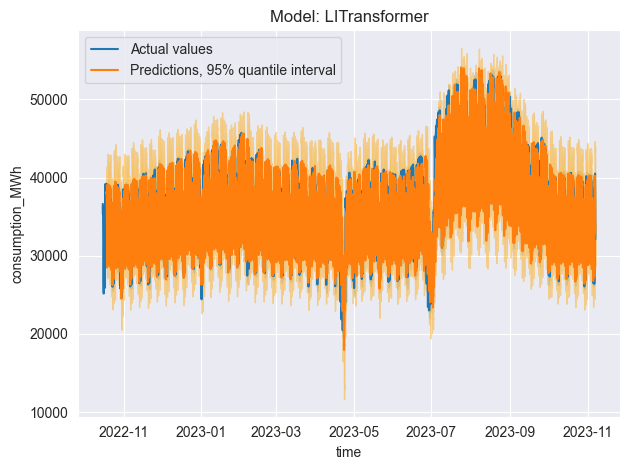

In [50]:
# Predicted vs. actual plot, hourly, entire test period
_ = plot_actual_predicted(df_test, df_preds, "LITransformer")

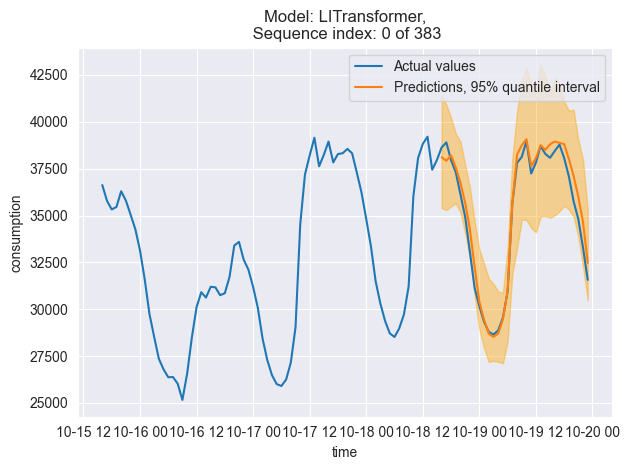

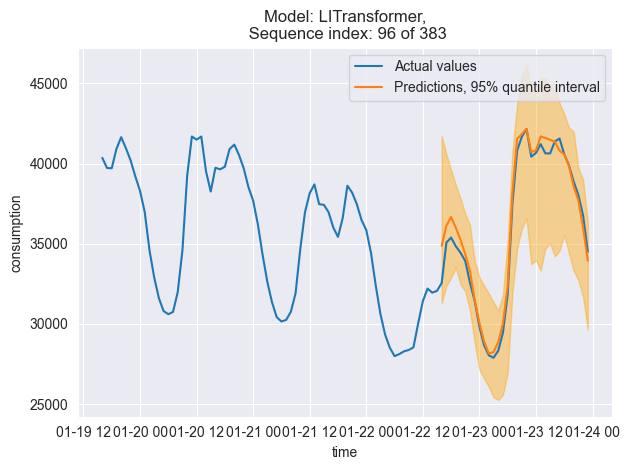

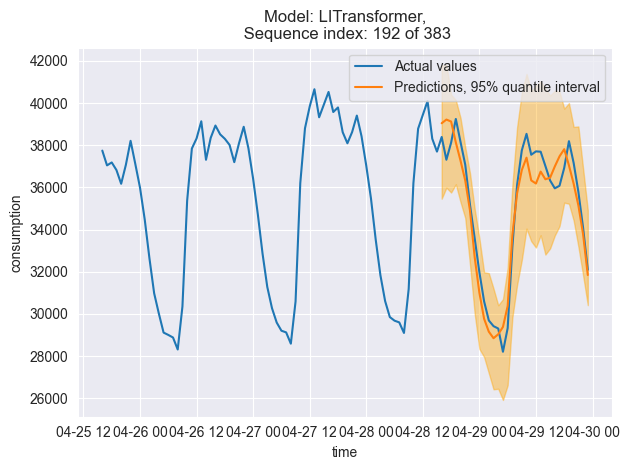

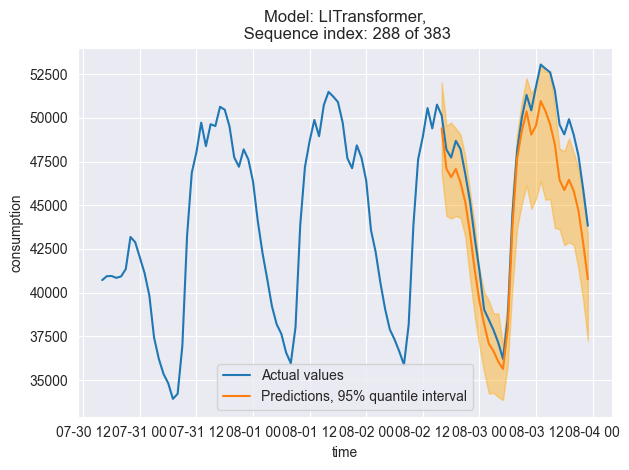

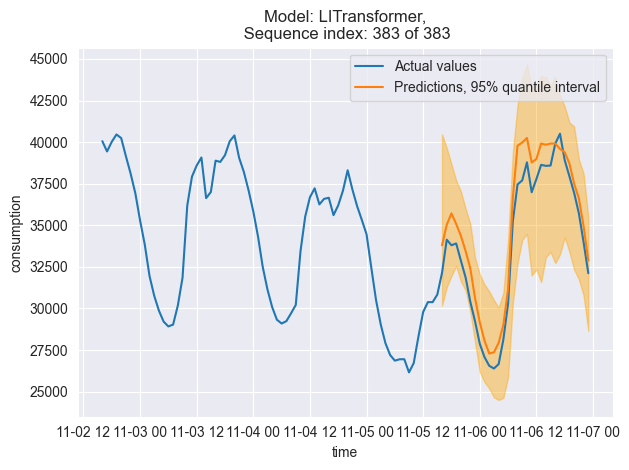

In [51]:
# Predicted vs. actual plots, zoomed in
indices = [i for i in range(0, len(test_target), len(test_target) // 4)]
indices.append(len(test_target) - 1)
for idx in indices:
    _ = plot_sequence_preds(preds, test_source, test_target, "LITransformer", sequence_index = idx)

In [52]:
# Calculate performance metrics: MAE, RMSLE, MAPE, pinball loss
calculate_metrics(df_test, df_preds, "LITransformer")

,Model: LITransformer
"MAPE, point",4.2411
"RMSLE, point",0.0613
"MAE, point",1554.1045
"Pinball loss, q: 2.5%",155.9924
"Pinball loss, q: 50.0%",777.0522
"Pinball loss, q: 97.5%",231.1468


Keep in mind that for the median quantile, pinball loss equals MAE / 2.